In [175]:
#Imports
import pandas as pd
import yfinance as yf
import os

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, precision_score

In [176]:
btc_ticker = yf.Ticker("BTC-USD") #Price of bitcoin relativ to the USD
if os.path.exists("btc.csv"):
    btc = pd.read_csv("btc.csv", index_col=0)
else:
    btc = btc_ticker.history(period="max")
    btc.to_csv("btc.csv")

In [177]:
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-01 00:00:00+00:00,109558.625000,110574.898438,109372.953125,110064.015625,25871668762,0.0,0.0
2025-11-02 00:00:00+00:00,110064.429688,111167.312500,109523.453125,110639.625000,34284209459,0.0,0.0
2025-11-03 00:00:00+00:00,110646.906250,110764.914062,105336.359375,106547.523438,72852006359,0.0,0.0


In [178]:
btc.index = pd.to_datetime(btc.index)#Convert to datetime to make it easier to work with

In [179]:
del btc["Dividends"]
del btc["Stock Splits"]

<Axes: xlabel='Date'>

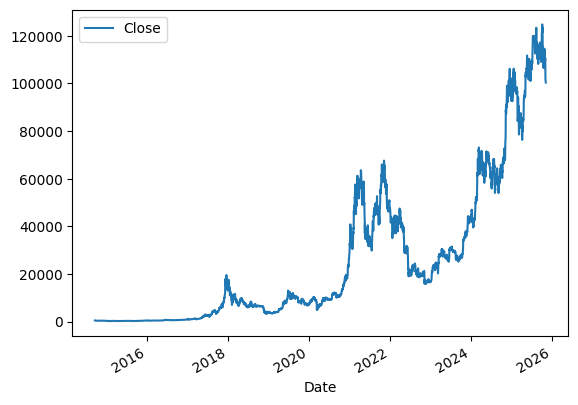

In [180]:
btc.plot.line(y="Close", use_index=True)

In [181]:
wiki = pd.read_csv("wikipedia_edits.csv",index_col=0,parse_dates=True)


In [182]:
btc.index = btc.index.tz_localize(None)
btc = btc.merge(wiki, left_index=True, right_index=True)


In [183]:
btc

,Open,High,Low,Close,Volume,edit_count,sentiment,neg_sentiment
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718
...,...,...,...,...,...,...,...,...
2025-11-01,109558.625000,110574.898438,109372.953125,110064.015625,25871668762,0.900000,0.010056,0.157143
2025-11-02,110064.429688,111167.312500,109523.453125,110639.625000,34284209459,0.900000,0.010056,0.157143
2025-11-03,110646.906250,110764.914062,105336.359375,106547.523438,72852006359,0.966667,-0.023050,0.190476
2025-11-04,106541.421875,107264.882812,98962.062500,101590.523438,110967184773,0.966667,-0.023050,0.190476


In [184]:
btc["tomorrow"] = btc["Close"].shift(-1)

In [185]:
btc["target"] = (btc["tomorrow"]) > btc["Close"].astype(int)

In [186]:
btc["target"].value_counts()

target
True     2178
False    1890
Name: count, dtype: int64

In [187]:
model = RandomForestClassifier(n_estimators=100,min_samples_split=50,random_state=1)


train = btc.iloc[:-200]
test = btc[-200:]

predictors = ["Close", "Volume", "Open", "High", "Low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors],train["target"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,50
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [188]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.5714285714285714

In [189]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [190]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [197]:
model = XGBClassifier(random_state=1, learning_rate=.01, n_estimators=100)
predictions = backtest(btc, model, predictors)

In [198]:
precision_score(predictions["target"],predictions["predictions"])

0.5077910174152154

In [199]:
predictions

,target,predictions
2017-09-16,False,1
2017-09-17,True,1
2017-09-18,False,1
2017-09-19,False,1
2017-09-20,False,1
...,...,...
2025-11-01,True,0
2025-11-02,False,0
2025-11-03,False,1
2025-11-04,False,1
